# AED Accessibility Study in Catalonia  
### Analysis of Infrastructure, Geographic Distribution, and Accessibility Levels

This notebook analyzes the geographic distribution of Automated External Defibrillators (AEDs) across Catalonia, evaluating their accessibility based on location type, availability, and spatial distribution.
The data is obtained from the *OpenData portal of the Government of Catalonia* and is combined with official geographic datasets.


In [1]:
# 0. Importing Required Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from sodapy import Socrata
from shapely.geometry import Point
import re
import unicodedata
import unidecode
import matplotlib.colors as mcolors
from matplotlib import cm
import os

In [2]:
# Download data directly from portal Opendata
client = Socrata("analisi.transparenciacatalunya.cat", None)

desfibriladors = client.get_all("wpud-ukyg")   # AED in non clinical spaces

#Convert into DataFrame
df_desf = pd.DataFrame.from_records(desfibriladors)

#print(df_desf.columns)

In [3]:
# Create folder for plots
os.makedirs("plots", exist_ok=True)

## 1. Data Preprocessing

We begin by cleaning the dataset and selecting only the variables relevant to accessibility and geographic analysis.


In [4]:
# Clean DataFrame to the columns that are relevant for this study
cols_utils = [
    "nom_centre", "espai_fisic", "vehicle",
    "municipi", "comarca", "provincia", "titular",
    "latitud", "longitud"
]

df_desf = df_desf[cols_utils].copy()
print(len(df_desf))

11538


In [5]:
# Convert coordinates to number type
df_desf["latitud"] = pd.to_numeric(df_desf["latitud"], errors="coerce")
df_desf["longitud"] = pd.to_numeric(df_desf["longitud"], errors="coerce")

In [6]:
# Homogenize data: 

# List of text columns to homogenize
cols_text = [
     "vehicle", "nom_centre", "tipus_via",
    "nom_via", "espai_fisic", "municipi", "comarca", "provincia", "titular"
]

# Function to remove accents from a string
def remove_accents(text):
    text = unicodedata.normalize('NFKD', text)
    text = "".join(c for c in text if not unicodedata.combining(c))
    return text

# Loop through each text column in the DataFrame
for c in cols_text:
    if c in df_desf.columns:
        
        # Replace NaN values with empty strings, convert all values to string, and lowercase
        df_desf[c] = df_desf[c].fillna("").astype(str).str.lower()
        # Apply the remove_accents function to remove accents from all values
        df_desf[c] = df_desf[c].apply(remove_accents)

#df_desf.head()


In [7]:
df_desf['municipi'].value_counts().head(10)

municipi
barcelona                      2728
lleida                          278
igualada                        249
hospitalet de llobregat, l'     195
sabadell                        185
girona                          179
tarragona                       178
prat de llobregat, el           171
terrassa                        165
sant cugat del valles           136
Name: count, dtype: int64

## 2. Accessibility Classification

Each AED is classified as **High**, **Medium**, or **Low** accessibility based on two factors:

1. **Opening hours** (public 24/7, commercial hours, or restricted)  
2. **Physical access** (open public space vs. controlled/private access)

### How the classification works

**Step 1 — Detect infrastructure type**  
A large keyword dictionary (`CATEGORIES`) groups text fields (`nom_centre`, `espai_fisic`, `titular`) into categories such as transport, education, commercial, administration, residential, outdoors, etc.

**Step 2 — Map infrastructure to accessibility**  
Using `mapa_categories`, each category is assigned an accessibility level:

- **High** — outdoor or fully public spaces (e.g. street, square, station)  
- **Medium** — places open during business hours (e.g. supermarkets, gyms)  
- **Low** — private, restricted, or staff-only spaces (e.g. schools, offices)  
- **Vehicle** — mobile AEDs detected via specific tokens  
- **Unclassified** — no keyword match


In [18]:
CATEGORIES = {
    # ------------------------
    # OBLIGATORIS PER LLEI
    # ------------------------

    "OBLIGATORI (Hotel)": [
        "HOTEL", "NOVOTEL", "NH", "MELIA", "MARINA", "HILTON"],
 
    "OBLIGATORI (Transport)": [
        "AEROPORT", "PORT", "PORTS", "AEROPORTS",
        "PRACTICOS PUERTO", "AUTORIDAD PORTUARIA", "ADIF",
        "BARCELONA CRUISE TERMINAL", "TERMINAL DE CONTENIDORES",
        "TERMINAL ETERMINAL", "TRANSPORT", "FERRY", "TMB",
        "METRO", "ANDANA", "AREA METROPOLITANA", "SINDICATURA"

    ],

    "OBLIGATORI (Estació)": [
        "ESTACIO", "ESTACIÓN", "RENFE", "FGC", "METRO",
        "FERROCARRILS", "RODALIES", "ESTACIO", "METRO", "FGC", "RENFE", "TRAM"
    ],

    "OBLIGATORI (Recinte esportiu)": [
        "PAVELLO", "PAVELLÓ", "POLIESPORTIU", "ESTADI", "FUTBOL",
        "CAMP", "RECINTE ESPORTIU", "CLUB ESPORTIU", "CLUB",
        "GIMNAS", "GYM", "FITNESS", "ESCUDERIA", "UNIO ESPORTIVA",
        "UNIO ATLETICA", "ESPORTS PER A DISMINUITS",
        "CENTRE INTERNACIONAL DE VELA", "JUNIOR F.C.",
        "AGRUPACIO VETERANS JUGADORS F.C. BARCELONA",
       "FEDERACIO",
        "TENNIS", "C.F", "UNIFICACIO ESPORTIVA", "PADEL", "VESTIDORS", "ISMA"

    ],

    # -----------------------
    # INFRAESTRUCTURA PÚBLICA
    # ------------------------

    "PUBLIC (Administració)": [
        "AJUNTAMENT","AJUNTMENT", "GENERALITAT", "DIPUTACIO", "DIPUTACIÓN",
        "DEPARTAMENT", "OFICINA MUNICIPAL", "DISTRICTE",
        "CONSELL COMARCAL", "COMISION", "COMISSIO", "CSIC",
        "SERVEI PUBLIC D'OCUPACIO", "SECRETARIAT",
        "CONSEJO SUPERIOR", "PATRIMONI CULTURAL",
        "TESORERIA GENERAL", "SOC OFICINA DEL TREBALL",
        "GESTIO ECONOMICA", "AEAT", "DELEGACION AEAT",
        "DELEGACIO DE GOVERN",
        "ENTITAT MUNICIPAL DESCENTRALITZADA DE VALLDOREIX",
        "PARLAMENT", "GOVERN", "SERVEI PUBLIC D?OCUPACIO DE CATALUNYA",
        "TRAFICO", "SOC", "AGENCIA", "SEPE",
        "AJUANTAMENT", "REGISTRE MERCANTIL DE BARCELONA",
        "INSPECCIO PROVINCIAL DE TREBALL I SEGURETAT SOCIAL (IPTSS)",
        "CONSEJO GENERAL DEL PODER JUDICIAL",
        "INSPECCIO PROVINCIAL DE TREBALL I SEGURETAT SOCIAL",
        "ENTITAT AUTÒNOMA DEL DIARI OFICIAL I PUBLICACIONS (DOGC)",
        "ACONDICIONAMIENTO TARRENSE (LEITAT)",
        "INFORMACIÓ I COMUNICACIÓ BARCELONA", "BTV",
        "LABORATORI DE LLUM SÍNCROTRÓ", "SINCROTRÓ",
        "CONSTRUCCIÓ, EQUIP. I EXPLOT. DEL LAB. DE LLUM SÍNCROTRÓ",
        "ENTITAT AUTONOMA DEL DIARI OFICIAL I DE PUBLIC",
        "ENTITAT", "DIARI"

    ],



    "PUBLIC (Educació)": [
        "ESCOLA", "INSTITUT", "INS", "UNIVERSITAT", "VEDRUNA", "FACULTAT", "COL", "LEGI"
        "CAMPUS", "FEDAC", "COL.LEGI", "COL·LEGI", "LA SALLE",
        "FORMACIO", "EPEL", "COLEGIO", "HERMANAS",
        "CONGREGACION", "CASA COLEGIO", "LICEO",
        "IES MONTSERRAT", "LES ALZINES", "INSTITUTO ALEMAN",
        "INSTITUTO NACIONAL DE SEGURIDAD Y SALUD",
        "FUNDACION PRIVADA BENJAMIN FRANKLIN", "EOI",
        "SCHOOL", "INSTITUCIO MONTSERRAT",
        "AGRUPACIO PEDAGOGICA SANT NICOLAU",
        "THE BRITISH SCHOOL", "ESTUDIOS", "ESTUDIO",
        "CIFO", "IES", "INS", "CEE", "CIC", "ENSENYAMENT",
        "SALESIANAS", "INSTITUTO", "SEMINARI", "SEMINARIO",
        "CFA", "ESCUELA", "CENTRE VIL*LA JOANA",
        "RIERA SANT MIQUEL 1/3", "SIGMA GESTION UNIVERSITARIA AIE", "LES ALZINES", "VIL*LA", "CASA DE JESUS I MARIA"

    ],



    "PUBLIC (Sanitari)": [
        "HOSPITAL", "CAP ", "CAP-", "AMBULATORI",
        "CLINIC", "CLÍNIC", "CENTRE MEDIC", "CENTRE MÈDIC",
        "SALUT", "FARMACIA", "CENTRE DE RECUPERACIO XIROI",
        "CENTRO DE RECUPERACION", "FISIO"
    ],



    "PUBLIC (Equipament)": [ "BIBLIOTECA", "MUSEU", "TEATRE", "CASAL", 
                             "ESPORT", "ATENEU", "VIL*LA JOANA", "CENTRE COMARCAL LLEIDATA", 
                             "PATRONAT MUNICIPAL D'ESPORTS", "BASILICA SAGRADA FAMILIA", "LLUISOS", 
                             "POBLE ESPANUOL", "CCCB", "CENTRE CIVIC", "C. CIVIC", "CENTRE DE CULTURA", 
                             "CENTRE CULTURAL", "CENTRE CULTURAL ELS CATALANISTES", "EL CERCLE DE GRÀCIA"

    ],

    "SERVEIS D'EMERGÈNCIA": [
        "BOMBERS", "MOSSOS", "POLICIA", "GUARDIA URBANA",
        "PROTECCIO CIVIL"

    ],



    # ------------------------
    # PRIVAT D'ÚS PÚBLIC
    # ------------------------

    "PRIVAT ÚS PÚBLIC (Comerç / Oci)": [
     "SUPERMERCAT", "MERCAT", "CENTRE COMERCIAL", "BOTIGA",
    "RESTAURANT", "BAR", "DISCOTECA", "CINEMA",
     "LES GLORIES", "C.P. JOAQUIM AMAT",
        "F. JUNTA CONSTRUCTORA TEMPO EXPIATORIO SAGRADA",
        "ARENAS", "MAQUINISTA", "COOPERATIVA", "CONSUM",
        "DREAMFIT SANT BOI", "ESDA LLOTJA",
        "AMIX-IMPLANT SLPU", "DIA", "CAIACS", "LLOGUER"

    ],



    "PRIVAT ÚS PÚBLIC (Gimnàs)": [
        "GIMNAS", "GYM", "FITNESS", "PILATES", "PADEL"

    ],



    "PRIVAT ÚS PÚBLIC (Sanitari / Residencial)": [
        "RESIDENCIAL", "RESIDENCIA", "MUTUAL", "MUTUA",
        "JESUS COSTA VILA", "CP", "JORDI VIOLAN",
        "INTERCENTROS BALLESOL", "CASA SANTIVERI",
        "MUTUALITAT CATALANA DE FUTBOLISTES", "GERIATRIC", "C.P"
    ],



    # ------------------------
    # TERCER SECTOR
    # ------------------------

    "FUNDACIONS / ONG": [
        "ONG", "ORGANITZACIO", "ORGANIZACION", 
        "ASSOCIACIO", "ASOCIACION", "FUNDACIO",
        "FUNDACIÓN", "FUNDATION", "FUNDACION",
        "CREU ROJA", "CARITAS", "CÀRITAS", "ONCE",
        "COTTOLENGO", "ALIMENTS", "CARES",
        "FUNDACION PRIVADA ST. PAUL'S",
        "FUNDACION SARQUAVITAE",
        "INTEGRACIO DE PERSONES EN RISC D'EXCLUSIO SOCIAL",
        "FOMENT CULTURAL I ARTISTIC",
        "GRAN LOGIA DE ESPAÑA",
        "GRAN LOGIA DE ESPAÑA DE BARCELONA",
        "CASTELLERS", "CASTELLS",
        "TESTIGOS CRISTIANOS DE JEHOVA",
        "CERCLE", "CATOLIC",
        "CENTRE CULTURAL", "CENTRE CULTURAL ELS CATALANISTES",
        "ORGANISME BENEFIC ASSISTENCIAL OBA", "OBA", "GRAN LOGIA", "associcacio"

    ],



    # ------------------------

    # ENTITATS PÚBLIQUES MIXTES

    # ------------------------

    "ENTITAT PÚBLICA / MIXTA": [
        "MANCOMUNITAT", "CONSORCI", "CONSORCIO",
        "SOCIETAT", "PATRONAT DE LA MUNTANYA DE MONTSERRAT",
        "TURISME", "MANCOMUNIDAD",
        "LABORATORI DE LLUM SÍNCROTRÓ", "SINCROTRÓ",
        "CONSTRUCCIÓ, EQUIP. I EXPLOT. DEL LAB. DE LLUM SÍNCROTRÓ", "CONSTRUCCIO"

    ],



    # ------------------------

    # PRIVAT / CORPORATIU INTERN

    # ------------------------

    "PRIVAT (Corporatiu / Oficines)": [
        "SA", "S.A", "SL", "S.L", "SLU", "SCCL", "SAU",
        "S.A.U", "SLP", "SCP", "EMPRESA",
        "CORPORACIO", "CORPORACIÓN", "OFICINES",
        "TORRE", "MAPFRE", "BANCO", "BANC",
        "VALORIZA", "DKV", "CASER", "GRAMAIMPULS",
        "VDF", "TELSTAR", "LABIANA", "CEETRUS",
        "UNIT4", "EXTERNALIZACION",
        "ALLIANCE HEALTHCARE",
        "ROBERTO LORENZO", "DEKRA", "RICOH",
        "BALMES II", "CAMBRA OFICIAL", "ABERTIS",
        "INMOBILIARIA COLONIAL",
        "BARCELONA SUPERCOMPUTING CENTER",
        "GOTEX", "GENIE INDUSTRIES",
        "AIGUES", "URIA MENENDEZ", "ZURICH",
        "VALLSOLANA GARDEN BUSINESS PARK",
        "ESQUERRA REPUBLICANA DE CATALUNYA",
        "BBVA", "LA CAIXA", "TELEFONICA",
        "UTE CONSERVACIO RONDES BARCELONA",
        "FIRA INTERNACIONAL DE BARCELONA",
        "GESTIO DE TERRES I RUNES AIE",
        "ROBOFIT", "MERSEN IBERICA",
        "BIOIBERICA", "XAVIER FRANCO EDO",
        "ANGEL QUEMADA", "METGES DE CATALUNYA",
        "MITSUBISHI", "UPS", "CAIXABANK",
        "BANKIA", "EDMOND",
        "CDAD PROP CL CALABRIA 235-239 SUBCOMUNIDAD",
        "B.BRAUN MEDICAL INTERNACIONAL",
        "GUIES DEL PIRINEU SCP",
        "CONSTRUCCIO, EQUIP. I EXPLOT DEL LAB.DE LLUM S...",
        "ATENTO TELESERVICIOS DE ESPANA",
        "CDAD. PROPIETARIOS C. COMERC. LLOBREGAT CENT",
        "SCOE", "UNIO CARAVANISTA DE CATALUNYA",
        "AVPC SANTA COLOMA 2013",
        "EQUIVALENZA MANUFACTORY",
        "LATHAM AND WATKINS LLP",
        "NOATUM LOGISTICS SPAIN",
        "IGLESIA COSECHA MUNDIAL", "BALFEGO",
        "CONONOA", "TOYOTA",
        "DISTRIBUCIONES CERYGRES",
        "QUIMICA", "FARMACÈUTICA",
        "CESPA", "SOCIEDAD ANONIMA METALOGRAFICA",   "IPA", "TAYLOR NELSON SOFRES",
        "JATCO FRANCE SAS SUCURSAL EN ESPAÑA",
        "MATERIALS SPAIN", "UTE", "AVICOLA",
        "FARMAINDUSTRIA", "OLANO", "PARTIT DELS SOCIALISTES DE CATALUNYA",
        "PERELADA COMERCIAL", "ARAG",
        "SIGMA GESTION UNIVERSITARIA AIE",
        "LUBRIZOL", "LUBRIZOL ADVANCED MATERIALS SPAIN",
        "DENTALOGIC", "DENTALOGIC CLINICA DENTAL",
        "TAYLO NELSON SOFRES", "ACOSU", "COBEGA EMBOTELLADOR",
        "JATCO FRANCE","TARRENSE", "SOCIEDAD LIMITADA", "SAL", "GL",
        "HORMIPRESA", "MOTOR", "CORPORATIVOS", "CORPORATIU"

    ],



    # ------------------------
    # PRIVAT COMUNITATS DE PROPIETARIS
    # ------------------------
    "PRIVAT (Comunitat de propietaris)": [
        "COMUNITAT DE VEINS", "COMUNIDAD DE VECINOS",
        "COMUNITAT DE PROPIETARIS",
        "COMUNIDAD DE PROPIETARIOS",
        "COMUNITAT REINA AMALIA, 12",
        "COMUNIDAD", "CDAD PROP C. COMERC. LLOBREGAT CENT",
        "CDAD", "CDAD.", "CDAD. PROPIETARIOS",
        "ENTIDAD ASOCI. VECINOS ZONA SUR SANT ANDREU",
        "SUBCOMUNIDAD","CDAD PROP CL CALABRIA 235-239 SUBCOMUNIDAD",
        "CDAD. PROP. CARRETERA DE L'HOSPITALET, 147-149", 
        "C.P", "C.P.", "PICASSO", "C", "P", "VALLDAURA"

    ],

    # ------------------------
    # PERSONALS
    # ------------------------

    "PERSONALS": [
        "NOELIA", "MERITXELL", "KILIAN", "JOSE", "GLORIA",
        "ORIOL", "MARCEL", "MANUEL", "SONIA",
        "GEMMA", "EDUARD", "JOELLE", "ISABEL",
        "JUAN", "OSCAR", "CRISTIAN", "JERONIMO",
        "REBECA", "YOLANDA", "RAFAEL CABALLERO RODRIGUEZ",
        "MARIA VICTORIA", "JOSEP", "JOAN", "MODESTO",
        "ALBERTO", "MARTA", "JAVIER",
        "XAVIER", "EDUARDO", "ANDRES",
        "ROSA", "ENRIQUE", "CRISTINA",
        "ALEX", "SALVADOR",
        "JOANA", "ALEIX", "PASTRANA",
        "PASCUAL", "RIGOL", "LARA",
        "FERNÁNDEZ", "MARTA BORONAT MARGALEF",
        "EDUARDO MONTSERRAT HERNANDEZ",
        "ANDRES PEREZ FLORES",
        "ROSA MA GIBERT"

    ],

    "EXTERIORS": ['exterior', "façana", "placa", "plaza", "parc", "parque",
        "carrer", "calle", "estacio", "plaça"]

}



In [19]:
## Associar accessibilitat
CATEGORIES_LOWER = {cat: [unidecode.unidecode(p.lower()) for p in words] for cat, words in CATEGORIES.items()}

mapa_categories = {
    "OBLIGATORI (Hotel)": "Alta",
    "OBLIGATORI (Transport)": "Alta",
    "OBLIGATORI (Estació)": "Alta",
    "OBLIGATORI (Recinte esportiu)": "Mitjana",
    "PUBLIC (Administració)": "Baixa",
    "PUBLIC (Educació)": "Baixa",
    "PUBLIC (Sanitari)": "Alta",
    "PUBLIC (Equipament)": "Mitjana",
    "SERVEIS D'EMERGÈNCIA": "Alta",
    "PRIVAT ÚS PÚBLIC (Comerç / Oci)": "Mitjana",
    "PRIVAT ÚS PÚBLIC (Gimnàs)": "Mitjana",
    "PRIVAT ÚS PÚBLIC (Sanitari / Residencial)": "Mitjana",
    "FUNDACIONS / ONG": "Baixa",
    "ENTITAT PÚBLICA / MIXTA": "Baixa",
    "PRIVAT (Corporatiu / Oficines)": "Baixa",
    "PRIVAT (Comunitat de propietaris)": "Baixa",
    "PERSONALS": "Baixa",
    "EXTERIORS": 'Alta'
}


# Creem sets finals per nivell
ALTA = set()
MITJANA = set()
BAIXA = set()

# Afegim paraules del diccionari de Barcelona
for cat, words in CATEGORIES_LOWER.items():
    nivell = mapa_categories.get(cat, "Baixa") # If not found, expect least accessibilty category as safety measure
    target_set = ALTA if nivell == "Alta" else MITJANA if nivell == "Mitjana" else BAIXA
    target_set.update(words)

# Paraules clau per detectar vehicles
vehicle_keywords = set(["sí", "si", "sì", "yes", "vehiculo", "vehicle", "cotxe", "portatil", "itinerant"])

def classify_accessibility(row):
    # 1. Preparació del text
    text = " ".join([
        str(row.get("nom_centre", "")),
        str(row.get("espai_fisic", "")),
        str(row.get("titular", "")),
        str(row.get("vehicle", ""))
    ])
    text = " ".join([str(row.get(col, "")) for col in ["nom_centre", "espai_fisic", "titular", "vehicle"]])
    text = unidecode.unidecode(text.lower())

    # 2. Comprovació de VEHICLE 
    if any(tok in vehicle_keywords for tok in text.split()):
        return "Vehicle"

    # 3. Comprovació de ALTA 
    if any(word in text for word in ALTA):
        return "High"

    # 4. Comprovació de MITJANA 
    if any(word in text for word in MITJANA):
        return "Medium"

    # 5. Comprovació de BAIXA 
    if any(word in text for word in BAIXA):
        return "Low"

    # 6. Si no coincideix amb res
    return "No classificat"

In [20]:
# Assignem la classificació 
df_desf["accessibilitat"] = df_desf.apply(classify_accessibility, axis=1)

In [21]:
# Filtrar els no classificats
no_classificats = df_desf[df_desf["accessibilitat"] == "No classificat"]

# Veure exemple
#print(no_classificats[["nom_centre", "espai_fisic", "titular"]].head(10))

# Extraure paraules que no apareixen en cap nivell
def get_unmatched_words(row):
    text = f"{row['nom_centre']} {row['espai_fisic']} {row['titular']}".lower()
    tokens = re.findall(r'\b\w+\b', text)
    unmatched = [t for t in tokens if t not in ALTA and t not in MITJANA and t not in BAIXA]
    return unmatched

# Afegim columna amb paraules no classificades
no_classificats = no_classificats.copy()
no_classificats["paraules_no_classificades"] = no_classificats.apply(get_unmatched_words, axis=1)

# Veure resultats
print(no_classificats[["nom_centre", "espai_fisic", "titular", "paraules_no_classificades"]].head(10))

#df_desf

Empty DataFrame
Columns: [nom_centre, espai_fisic, titular, paraules_no_classificades]
Index: []


In [22]:
# 1. Nombre total de DEA/AED (nombre de files)
total_deas = len(df_desf)

# 2. Recompte per cada nivell d'accessibilitat
recompte_accessibilitat = df_desf['accessibilitat'].value_counts()

print(f"Número Total de DEA/AED a l'estudi: {total_deas}")
print("-" * 40)
print("Distribució de DEA/AED per Nivell d'Accessibilitat:")
print(recompte_accessibilitat)

Número Total de DEA/AED a l'estudi: 11538
----------------------------------------
Distribució de DEA/AED per Nivell d'Accessibilitat:
accessibilitat
Low        5538
High       3188
Medium     2054
Vehicle     758
Name: count, dtype: int64


#### Also add the descriptive categories to our DataFrame
We add at which category the respectuve ADE belongs to from the dictionary made.

In [23]:
def detect_category(row):
    text = " ".join([
        str(row.get("nom_centre", "")),
        str(row.get("espai_fisic", "")),
        str(row.get("titular", "")),
    ])
    text = unidecode.unidecode(text.lower())

    for cat, words in CATEGORIES_LOWER.items():
        if any(w in text for w in words):
            return cat

    return "No classificada"

df_desf["categoria_detectada"] = df_desf.apply(detect_category, axis=1)


#### Generalize these categories into big ones to make more simple plots.

In [24]:
# To plot!

macro_categories = {
    "Mandatory": [
        "OBLIGATORI (Hotel)", "OBLIGATORI (Transport)", "OBLIGATORI (Estació)", "OBLIGATORI (Recinte esportiu)"
    ],
    "Sports / Leisure": [
        "PRIVAT ÚS PÚBLIC (Gimnàs)", "PRIVAT ÚS PÚBLIC (Comerç / Oci)"
    ],
    "Administration & Public Services": [
        "PUBLIC (Administració)", "ENTITAT PÚBLICA / MIXTA", "EXTERIORS"
    ],
    "Education & Culture": [
        "PUBLIC (Educació)", "PUBLIC (Equipament)", "FUNDACIONS / ONG"
    ],
    "Healthcare / Residential": [
        "PUBLIC (Sanitari)", "PRIVAT ÚS PÚBLIC (Sanitari / Residencial)"
    ],
    "Emergency Services": [
        "SERVEIS D'EMERGÈNCIA"
    ],
    "Private / Offices / Communities": [
        "PRIVAT (Corporatiu / Oficines)", "PRIVAT (Comunitat de propietaris)", "PERSONALS"
    ]
}


In [25]:
def map_macro_categoria(row):
    for macro, cats in macro_categories.items():
        if row["categoria_detectada"] in cats:
            return macro
    return "Altres"

df_desf["macro_categories"] = df_desf.apply(map_macro_categoria, axis=1)


In [26]:
# Diccionari de categories amb indicació pública/privada
servei_public_privat = {
    "OBLIGATORI (Hotel)": "Private",
    "OBLIGATORI (Transport)": "Public",
    "OBLIGATORI (Estació)": "Public",
    "OBLIGATORI (Recinte esportiu)": "Public",
    "PUBLIC (Administració)": "Public",
    "PUBLIC (Educació)": "Public",
    "PUBLIC (Sanitari)": "Public",
    "PUBLIC (Equipament)": "Public",
    "SERVEIS D'EMERGÈNCIA": "Public",
    "PRIVAT ÚS PÚBLIC (Comerç / Oci)": "Private",
    "PRIVAT ÚS PÚBLIC (Gimnàs)": "Private",
    "PRIVAT ÚS PÚBLIC (Sanitari / Residencial)": "Private",
    "FUNDACIONS / ONG": "Private",
    "ENTITAT PÚBLICA / MIXTA": "Public",
    "PRIVAT (Corporatiu / Oficines)": "Private",
    "PRIVAT (Comunitat de propietaris)": "Private",
    "PERSONALS": "Private",
    "EXTERIORS": "Public"
}

# Afegir columna Tipus_Servei segons el nou diccionari
df_desf["Tipus_Servei"] = df_desf["categoria_detectada"].map(servei_public_privat)

# Comprovar
print(df_desf[["categoria_detectada", "Tipus_Servei"]].drop_duplicates())


                            categoria_detectada Tipus_Servei
0                PRIVAT (Corporatiu / Oficines)      Private
1                          OBLIGATORI (Estació)       Public
2               PRIVAT ÚS PÚBLIC (Comerç / Oci)      Private
3                        PUBLIC (Administració)       Public
5                 OBLIGATORI (Recinte esportiu)       Public
10                           OBLIGATORI (Hotel)      Private
17                            PUBLIC (Educació)       Public
25                       OBLIGATORI (Transport)       Public
43            PRIVAT (Comunitat de propietaris)      Private
115                           PUBLIC (Sanitari)       Public
122   PRIVAT ÚS PÚBLIC (Sanitari / Residencial)      Private
208                            FUNDACIONS / ONG      Private
322                         PUBLIC (Equipament)       Public
583                     ENTITAT PÚBLICA / MIXTA       Public
1970                       SERVEIS D'EMERGÈNCIA       Public
5304                  PR

In [27]:
# Final dataFrame:
df_desf 


,nom_centre,espai_fisic,vehicle,municipi,comarca,provincia,titular,latitud,longitud,accessibilitat,categoria_detectada,macro_categories,Tipus_Servei
0,edifici neotecman,oficines,no,celra,girones,girona,neotecman s.l.,42.032526,2.878938,Low,PRIVAT (Corporatiu / Oficines),Private / Offices / Communities,Private
1,ajuntament d'ultramort,via publica,no,ultramort,baix emporda,girona,ajuntament d'ultramort,42.037143,3.034587,High,OBLIGATORI (Estació),Mandatory,Public
2,oficines,planta baixa hall,no,barcelona,barcelones,barcelona,santa iglesia catedral basilica de barcelona,41.383404,2.175729,Medium,PRIVAT ÚS PÚBLIC (Comerç / Oci),Sports / Leisure,Private
3,ajuntament de rajadell,matricula: 8626kfn,no,rajadell,bages,barcelona,ajuntament de rajadell,41.727807,1.706058,Low,PUBLIC (Administració),Administration & Public Services,Public
4,- 8579bym,,si,"bisbal d'emporda, la",baix emporda,girona,ajuntament de la bisbal d'emporda,NaN,NaN,Vehicle,PUBLIC (Administració),Administration & Public Services,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11533,"aena sme, s.a.",t2-p10 (m5) puesto informacion,no,"prat de llobregat, el",baix llobregat,barcelona,"aena sme, sa",41.330503,2.094249,Low,PUBLIC (Educació),Education & Culture,Public
11534,mercat els encants barcelona fira bellcaire,esta ubicat a:passadis costat ascensor,no,barcelona,barcelones,barcelona,institut municipal de mercats de barcelona,41.401032,2.185652,Medium,PUBLIC (Educació),Education & Culture,Public
11535,- 8284bmw,vehicle de proteccio civil.,si,sant joan de les abadesses,ripolles,girona,ajuntament de sant joan de les abadesses,NaN,NaN,Vehicle,PUBLIC (Administració),Administration & Public Services,Public
11536,circulo ecuestre,recepcio,no,barcelona,barcelones,barcelona,cordis pirenaica sl,41.395660,2.154093,Low,PRIVAT (Corporatiu / Oficines),Private / Offices / Communities,Private


## 3. Plots !

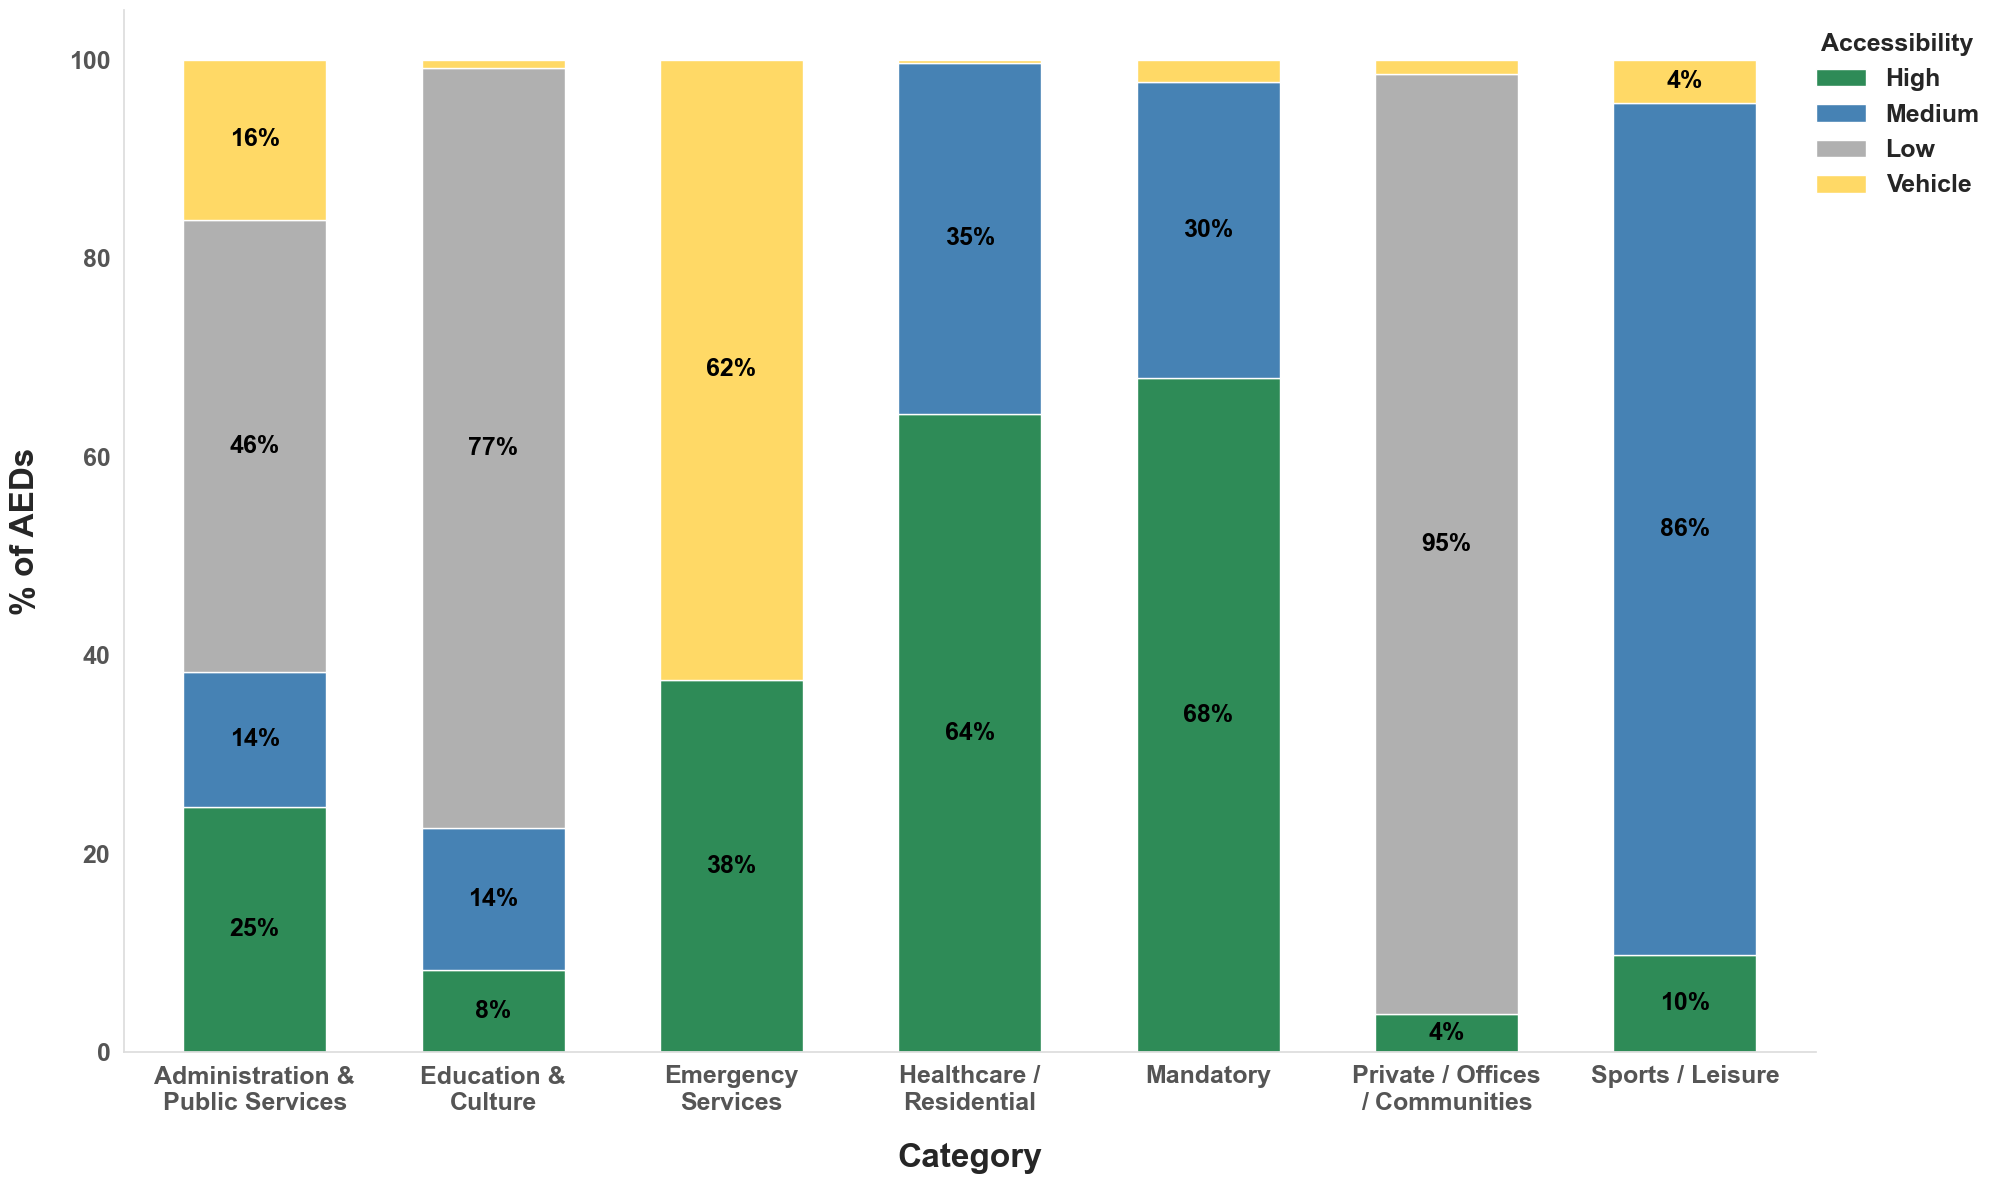

accessibilitat                     High Medium    Low Vehicle
macro_categories                                             
Administration & Public Services  24.7%  13.6%  45.6%   16.1%
Education & Culture                8.3%  14.3%  76.6%    0.9%
Emergency Services                37.5%   0.0%   0.0%   62.5%
Healthcare / Residential          64.3%  35.3%   0.0%    0.4%
Mandatory                         67.9%  29.8%   0.0%    2.3%
Private / Offices / Communities    3.8%   0.0%  94.8%    1.4%
Sports / Leisure                   9.8%  85.8%   0.0%    4.4%


In [49]:
## PLOTEJAR GRÀFIC DE BARRES PER VEURE RESULTATS

from textwrap import wrap

# Count AEDs by macro-category and accessibility
table = pd.crosstab(df_desf["macro_categories"], df_desf["accessibilitat"])
table_pct = table.div(table.sum(axis=1), axis=0) * 100  # convert to percentages

# Order of columns and updated colors
column_order = ["High", "Medium", "Low", "Vehicle"]
colors = {
    "High": "#2E8B57",    # verd
    "Medium": "#4682B4",  # blau
    "Low": "#B0B0B0",     # gris clar
    "Vehicle": "#FFD966"  # groc suau
}

sns.set(style="white")
plt.rcParams["font.family"] = "Arial"  # better font
plt.rcParams["font.weight"] = "bold"   # bold text

fig, ax = plt.subplots(figsize=(20,12))

# Plot stacked bar
table_pct[column_order].plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=[colors[c] for c in column_order],
    width=0.6,  # narrower bars for spacing
    edgecolor='white'
)

# Add percentages inside the bars
for p in ax.patches:
    height = p.get_height()
    if height > 3:  # only show if section is large enough
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_y() + height/2,
            f'{height:.0f}%',
            ha='center',
            va='center',
            fontsize=18,
            color='black',
            weight='bold'
        )

# Title and axis labels
ax.set_ylabel("% of AEDs", fontsize=24, labelpad=20, weight='bold')
ax.set_xlabel("Category", fontsize=24, labelpad=20, weight='bold')

# Wrap and rotate category names
ax.set_xticklabels([
    "\n".join(wrap(l.get_text(), 17)) for l in ax.get_xticklabels()
], rotation=0, ha='center', fontsize=20, color ='black')

# Y-axis tick labels bigger
ax.tick_params(axis='y', labelsize=18, colors='#555555')
ax.tick_params(axis='x', labelsize=18, colors='#555555')

# Legend styling
ax.legend(fontsize=18, title="Accessibility", title_fontsize=18, loc='upper right',
          bbox_to_anchor=(1.11, 1), frameon=False, ncol=1)

# Subtle axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

plt.savefig('plots/bar_plot.png')
plt.tight_layout()
plt.show()

df_desf[df_desf['macro_categories'] == 'Mandatory']['accessibilitat'].value_counts()

# Mostrar percentatges de cada categoria per anàlisi:
print(table_pct[column_order].round(1).astype(str) + "%")


In [29]:
# Mostrar el recompte de DEA/AED per a cada infracategoria
print("Distribució de DEA/AED per Infraestructura:")
print("-" * 50)
print(df_desf['macro_categories'].value_counts())

Distribució de DEA/AED per Infraestructura:
--------------------------------------------------
macro_categories
Administration & Public Services    3792
Private / Offices / Communities     2708
Mandatory                           2633
Education & Culture                 1623
Sports / Leisure                     500
Healthcare / Residential             266
Emergency Services                    16
Name: count, dtype: int64


## Territorial Visualization: Municipalities and Counties

This section loads spatial layers for:
- municipalities  
- counties  
- provinces  

and produces maps showing:
- AED distribution  
- geographic density  
- urban concentration  
- underserved areas  

These visualizations highlight potential coverage gaps.


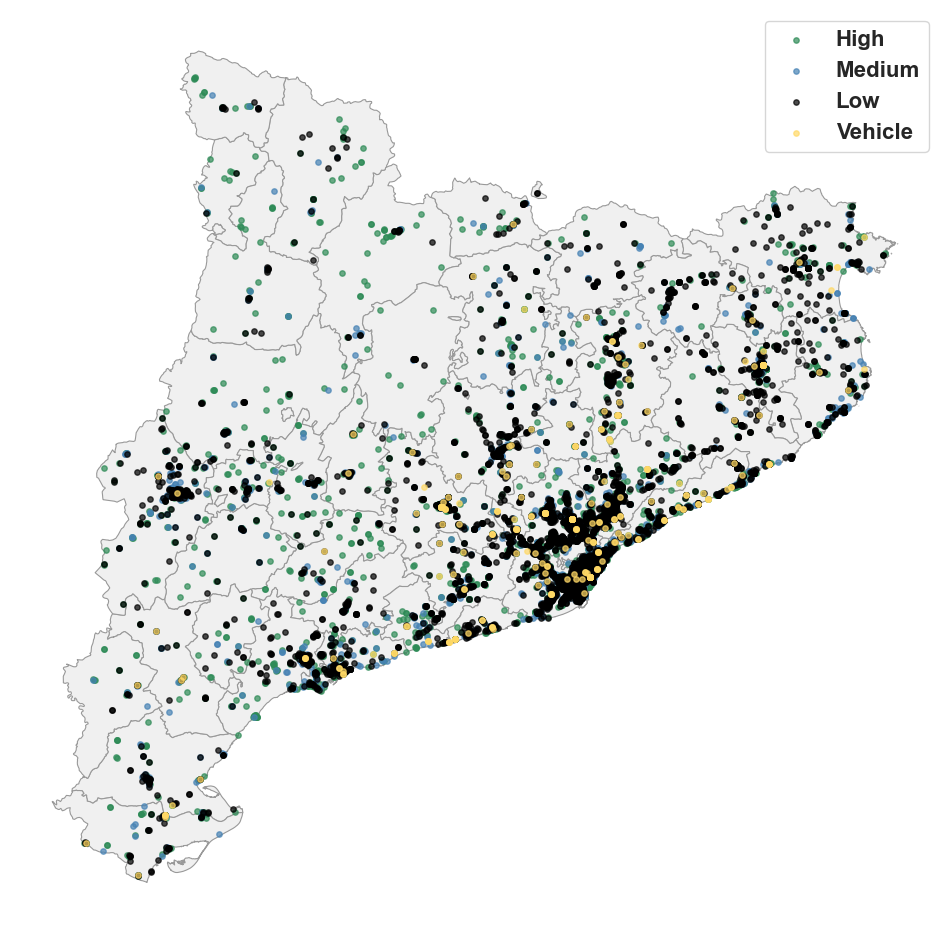

In [30]:
## AGAFAR MAPA DE CATALUNYA

# ---------------------------
# 1. Carregar comarques
# ---------------------------
gdf_comarques = gpd.read_file("carto/muni.json")  # Fitxer amb polígon de cada comarca

# Reparar geometries amb buffer(0)
gdf_comarques["geometry"] = gdf_comarques["geometry"].buffer(0)

# dissolve per comarca
gdf_comarques = gdf_comarques.dissolve(by="NOMCOMAR", as_index=False)


# ---------------------------
# 2. Preparar AED
# ---------------------------
# Convertir lat/lon a float
df_desf["latitud"] = df_desf["latitud"].astype(float)
df_desf["longitud"] = df_desf["longitud"].astype(float)

# Filtrar punts dins Catalunya
df_desf_valid = df_desf[
    (df_desf["latitud"] >= 40.5) & 
    (df_desf["latitud"] <= 42.8) &
    (df_desf["longitud"] >= 0.0) & 
    (df_desf["longitud"] <= 3.5)
].copy()

# Crear GeoDataFrame
geometry = [Point(xy) for xy in zip(df_desf_valid["longitud"], df_desf_valid["latitud"])]
gdf_desf = gpd.GeoDataFrame(df_desf_valid, geometry=geometry, crs="EPSG:4326")

# ---------------------------
# 3. Colors AED
# ---------------------------
# Filter out Not classified
gdf_desf_valid_classified = gdf_desf[gdf_desf["accessibilitat"] != "Not classified"]

# Colors for only classified levels
access_colors_filtered = {
    "High": "#2E8B57",    # verd
    "Medium": "#4682B4",  # blau
    "Low": "#000000",     # negre
    "Vehicle": "#FFD966"  # groc
}

# Scatter plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf_comarques.plot(ax=ax, color="#f0f0f0", edgecolor="#999999", linewidth=0.8)

for level, color in access_colors_filtered.items():
    subset = gdf_desf_valid_classified[gdf_desf_valid_classified["accessibilitat"] == level]
    subset.plot(ax=ax, markersize=15, color=color, label=level, alpha=0.7)
    

ax.axis("off")
ax.legend(fontsize=16)
filename = os.path.join("plots", "Catalunya")
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# --------------------------

In [31]:
## Carregar dades de BCN:
gdf_districtes = gpd.read_file("data/districtes.geojson")
gdf_districtes["geometry"] = gdf_districtes["geometry"].buffer(0)

gdf_barris = gpd.read_file("data/barris.geojson") 
gdf_barris["geometry"] = gdf_barris["geometry"].buffer(0) 

df_desf["latitud"] = df_desf["latitud"].astype(float)
df_desf["longitud"] = df_desf["longitud"].astype(float)
geometry = [Point(xy) for xy in zip(df_desf["longitud"], df_desf["latitud"])]

gdf_desf = gpd.GeoDataFrame(df_desf, geometry=geometry, crs="EPSG:4326")
gdf_desf = gdf_desf.to_crs(gdf_districtes.crs)
bcn_polygon = gdf_districtes.unary_union
gdf_desf_bcn = gdf_desf[gdf_desf.geometry.within(bcn_polygon)].copy()

df_densitat = pd.read_csv("data/densitat_bcn.csv") # CSV amb població i superfície
df_densitat.rename(columns={"Codi_Barri": "BARRI"}, inplace=True)
df_densitat["BARRI"] = df_densitat["BARRI"].astype(str).str.zfill(2)



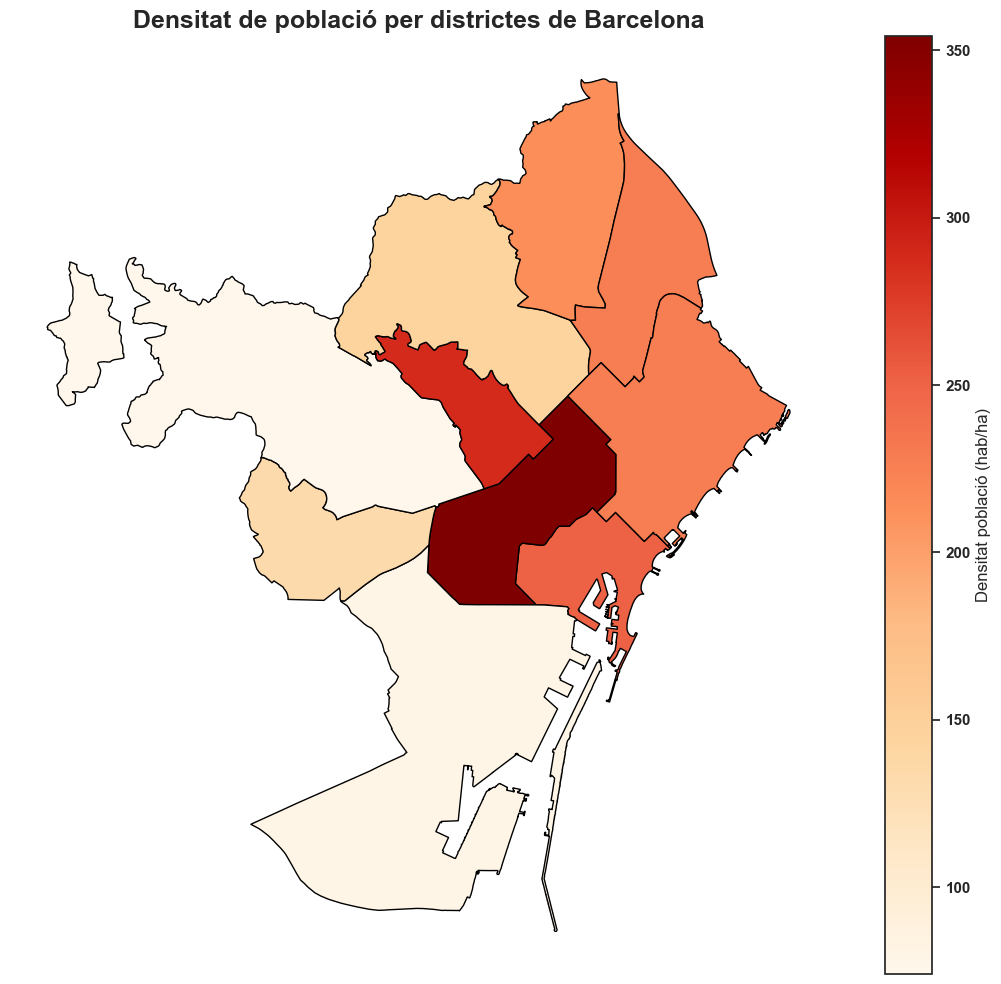

Districtes per densitat (hab/ha):
         Nom_Districte  Població  Superfície (ha)  Densitat (hab/ha)
1             Eixample    264353            746.4         354.170686
5               Gràcia    121438            422.4         287.495265
0         Ciutat Vella    105829            420.5         251.674197
9           Sant Martí    238245           1043.8         228.247749
8          Sant Andreu    150407            659.2         228.165959
7           Nou Barris    171883            805.7         213.333747
6       Horta-Guinardó    172199           1191.9         144.474369
3            Les Corts     80577            601.0         134.071547
2       Sants-Montjuïc    184367           2288.0          80.579983
4  Sarrià-Sant Gervasi    147434           1991.5          74.031634


In [32]:
# Merge GeoDataFrame amb dades de població
gdf_barris = gdf_barris.merge(
    df_densitat[["BARRI", "Població", "Superfície (ha)"]],
    left_on="BARRI",
    right_on="BARRI"
)


# Agrupar pel codi de districte que ja hi ha al GeoJSON
gdf_districtes = gdf_barris.dissolve(
    by="DISTRICTE", 
    aggfunc={'Població':'sum', 'Superfície (ha)':'sum'}
).reset_index()

# Calcular densitat per districtes
gdf_districtes["Densitat (hab/ha)"] = gdf_districtes["Població"] / gdf_districtes["Superfície (ha)"]

districte_nom = {
    "01": "Ciutat Vella",
    "02": "Eixample",
    "03": "Sants-Montjuïc",
    "04": "Les Corts",
    "05": "Sarrià-Sant Gervasi",
    "06": "Gràcia",
    "07": "Horta-Guinardó",
    "08": "Nou Barris",
    "09": "Sant Andreu",
    "10": "Sant Martí"
}
gdf_districtes["Nom_Districte"] = gdf_districtes["DISTRICTE"].map(districte_nom)


#PLOTS
fig, ax = plt.subplots(figsize=(12, 10))
gdf_districtes.plot(
    column="Densitat (hab/ha)",
    ax=ax,
    cmap="OrRd",
    linewidth=1,
    edgecolor="black",
    legend=True,
    legend_kwds={'label': "Densitat població (hab/ha)"}
)
ax.set_title("Densitat de població per districtes de Barcelona", fontsize=18, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.show()

# Ordenar per densitat descendent
df_districte = gdf_districtes[["Nom_Districte", "Població", "Superfície (ha)", "Densitat (hab/ha)"]]
df_districte = df_districte.sort_values("Densitat (hab/ha)", ascending=False)

print("Districtes per densitat (hab/ha):")
print(df_districte)


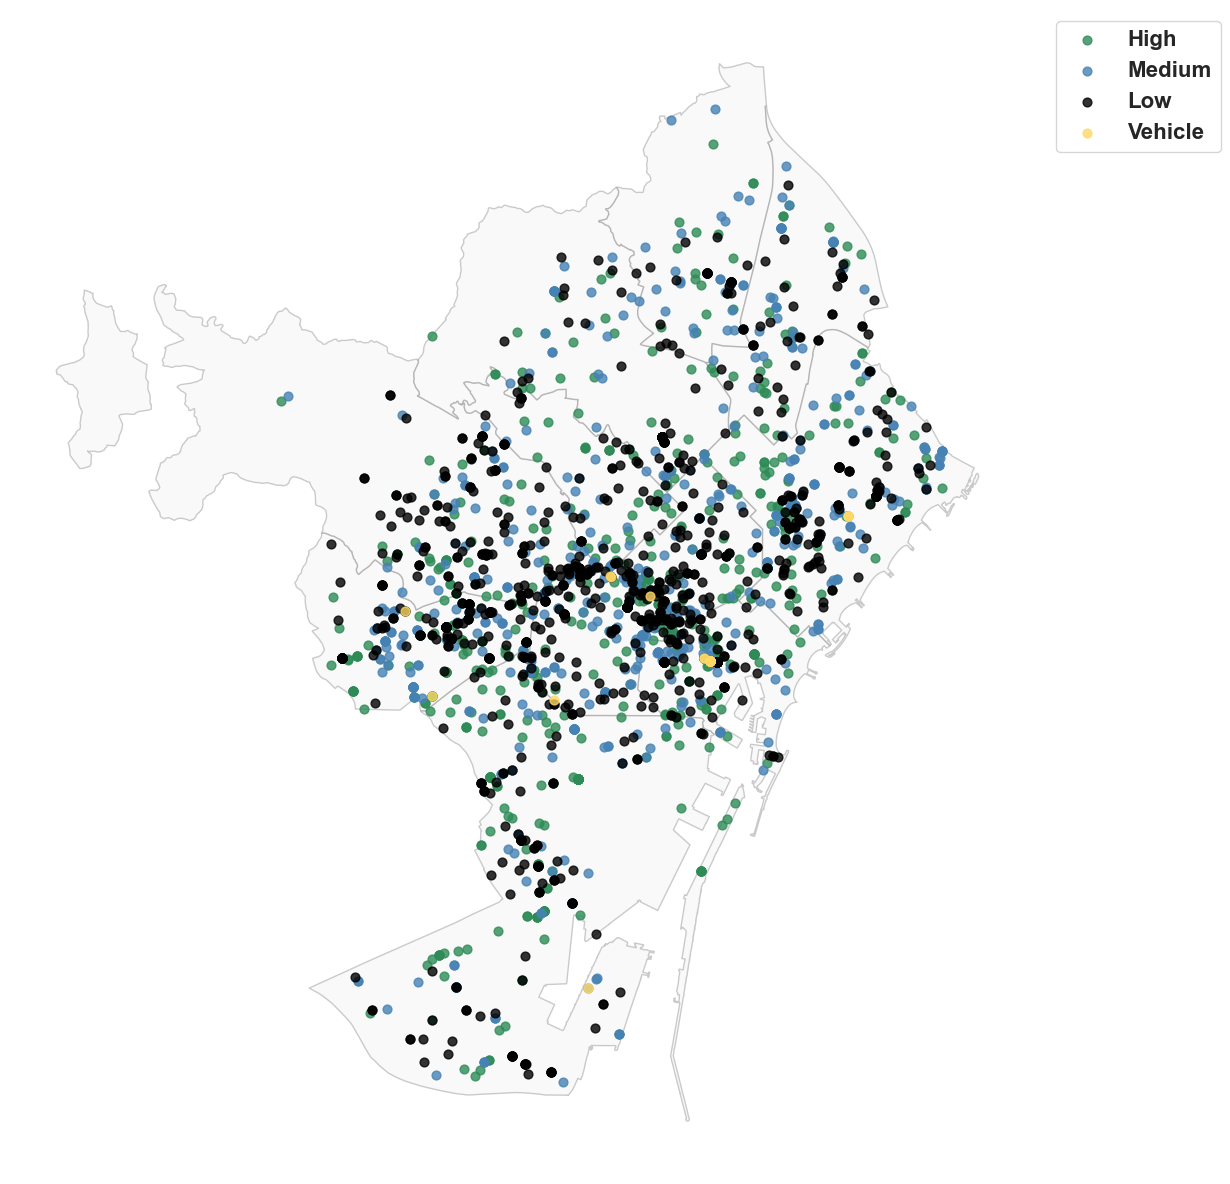

Number of AEDs inside Barcelona districts: 2694


In [33]:
# Colors for accessibility
access_colors_cb = {
    "High": "#2E8B57",    # verd
    "Medium": "#4682B4",  # blau
    "Low": "#000000",     # negre
    "Vehicle": "#FFD966"  # groc subtil
}

# Crear figura
fig, ax = plt.subplots(figsize=(14, 12))

# Dibuixar districtes de BCN
gdf_districtes.plot(
    ax=ax,
    color='#f5f5f5',       # gris clar
    edgecolor='#999999',   # línies suaus
    linewidth=1.0,
    alpha=0.5
)

# Plot AEDs per nivell d'accessibilitat
for level, color in access_colors_cb.items():
    subset = gdf_desf_bcn[gdf_desf_bcn['accessibilitat'] == level]
    if len(subset) > 0:
        subset.plot(
            ax=ax,
            markersize=40,         
            color=color,
            label=level,          
            alpha=0.8
        )

# Llegenda més clara
ax.legend(
    fontsize=16,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

# Treure eixos
ax.axis('off')

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/Barcelona_AEDs.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Number of AEDs inside Barcelona districts: {len(gdf_desf_bcn)}")


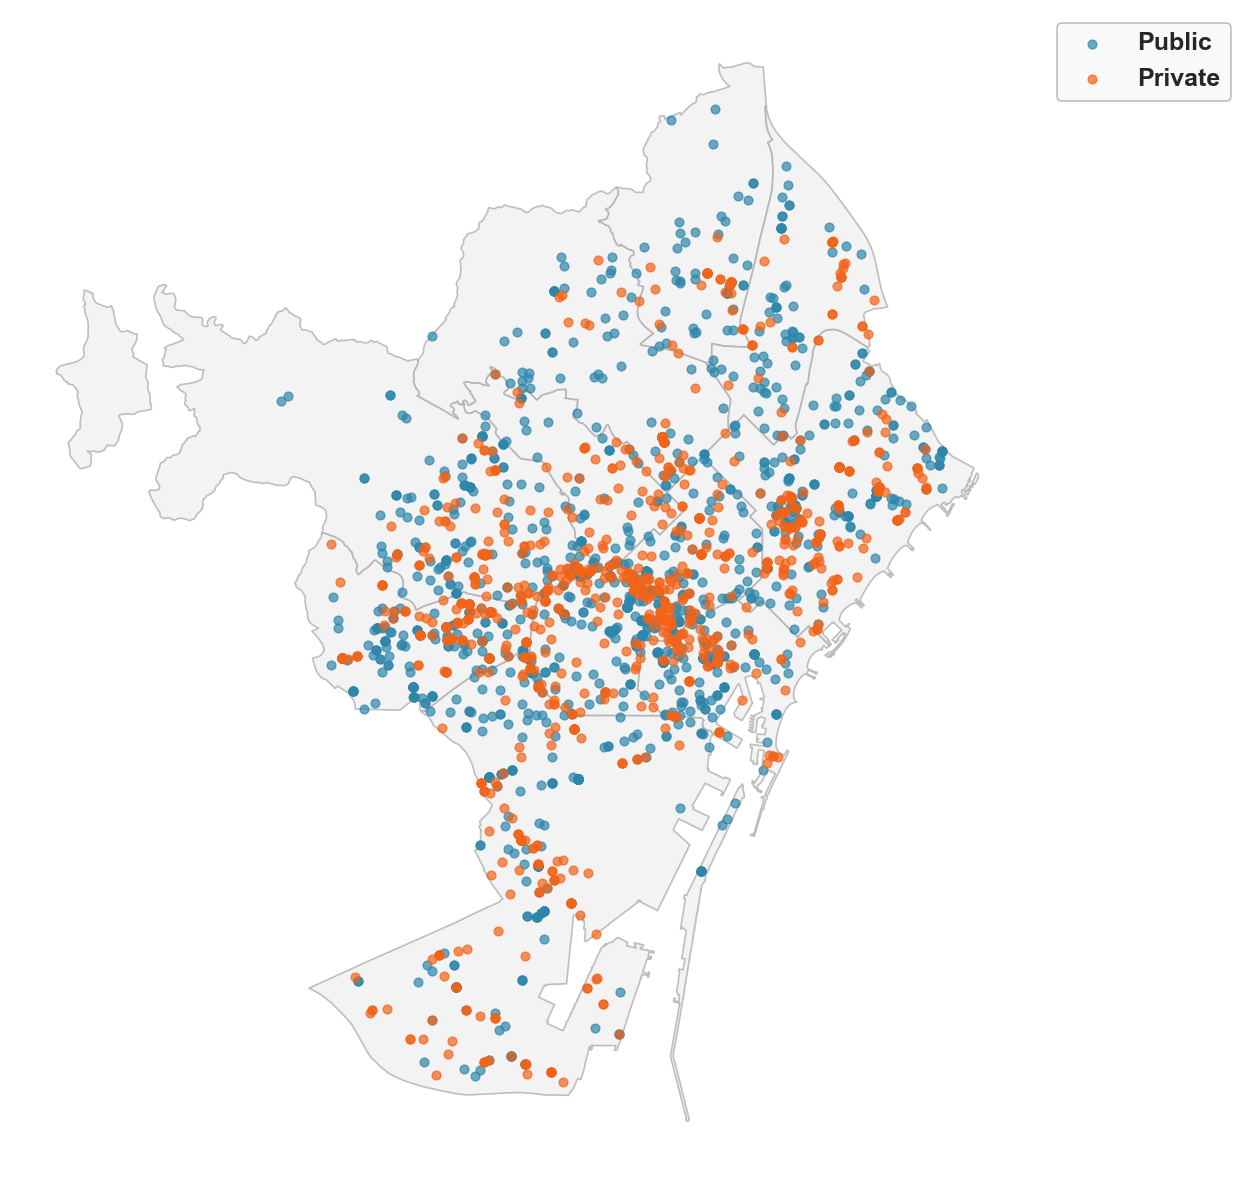

Nombre de DEA dins Barcelona: 2694


In [34]:
## PLOT PÚBLIC VS PRIVAT

# Colores millorats (tons més elegants)
servei_colors = {
    "Public": "#2E86AB",   # blau elegant
    "Private": "#F26419"    # taronja suau
}

fig, ax = plt.subplots(figsize=(14, 12))

# Dibuixar districtes de BCN amb un gris subtil i línies suaus
gdf_districtes.plot(
    ax=ax,
    color="#F0F0F0",      # gris clar neutre
    edgecolor="#B0B0B0",  # gris mitjà per contorn
    linewidth=1.2,
    alpha=0.8
)

# DEA per tipus de servei amb transparència i punts més elegants
for servei, color in servei_colors.items():
    subset = gdf_desf_bcn[gdf_desf_bcn["Tipus_Servei"] == servei]
    subset.plot(
        ax=ax,
        markersize=40,       # punts més grans
        color=color,
        label=servei,
        alpha=0.7)

legend = ax.legend(
    fontsize=18,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)
legend.get_frame().set_facecolor("#F8F8F8")
legend.get_frame().set_edgecolor("#B0B0B0")
legend.get_frame().set_linewidth(1.2)

# Eliminar eixos
ax.axis("off")

# Guardar
os.makedirs("plots", exist_ok=True)
plt.tight_layout()
plt.savefig("plots/Barcelona_public_priv.png", dpi=300, bbox_inches='tight')
plt.show()


print(f"Nombre de DEA dins Barcelona: {len(gdf_desf_bcn)}")

/var/folders/p8/854sw5z13s1_xzp8dpwctx1m0000gn/T/ipykernel_1470/1818325494.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(unique_categories))


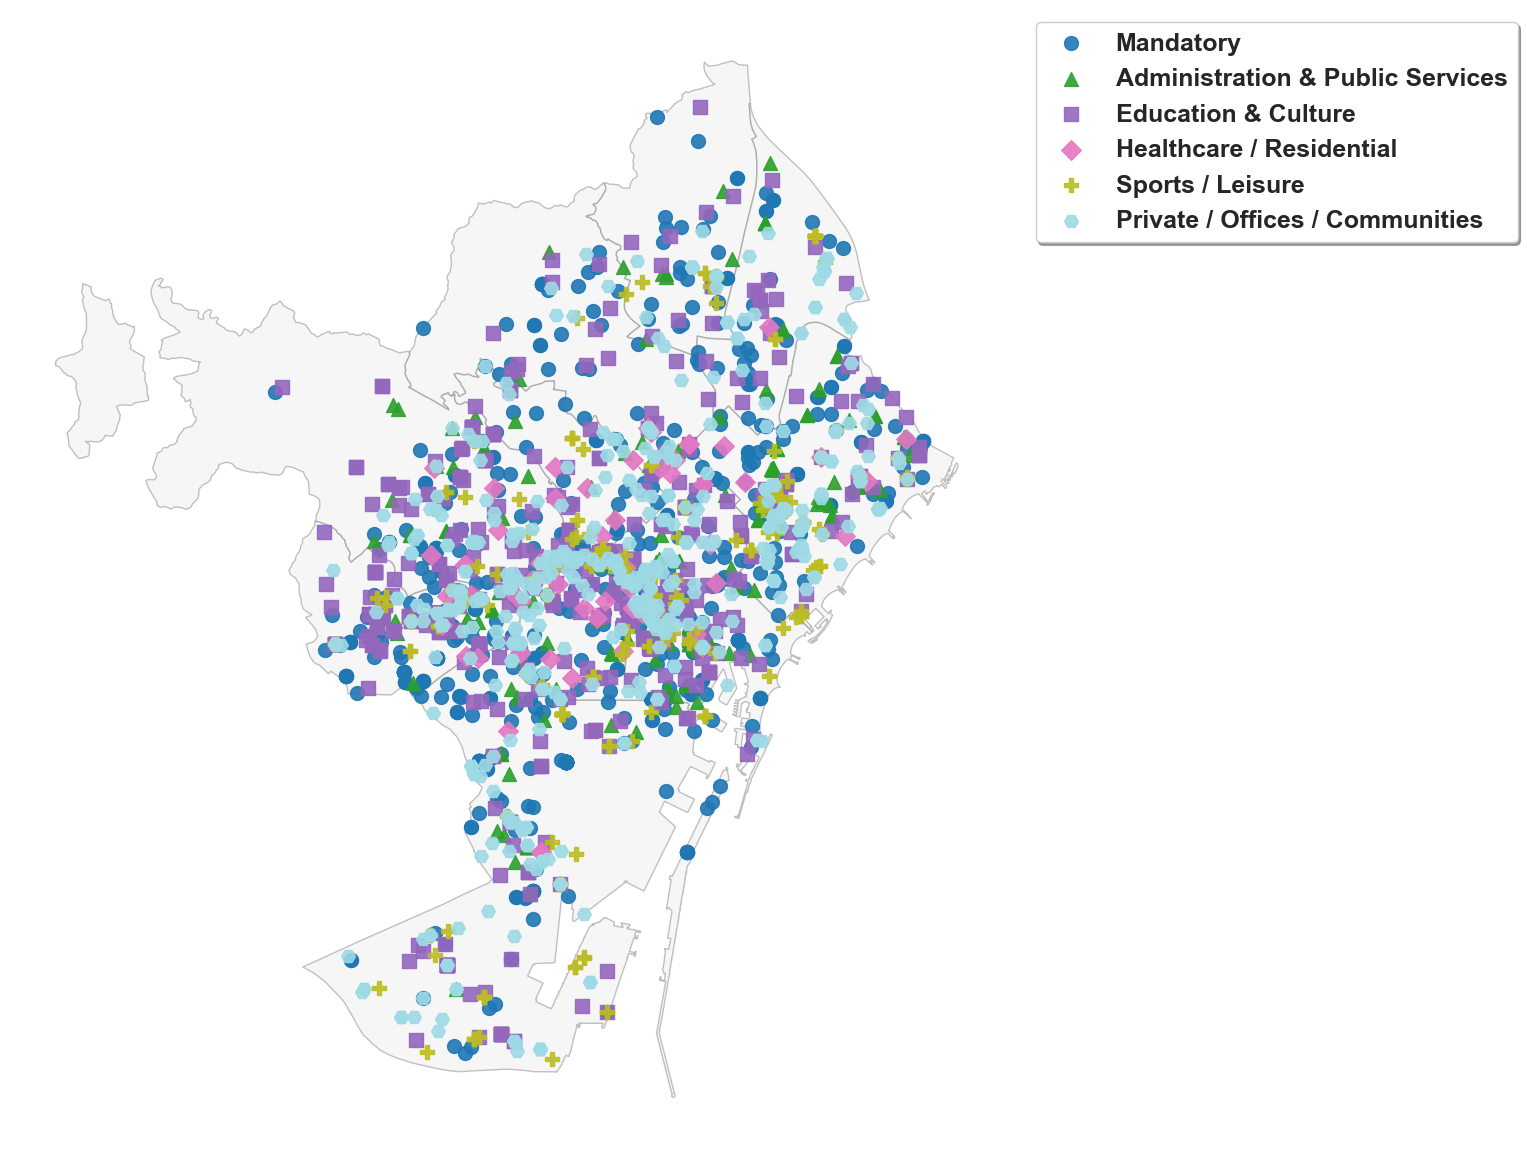

In [35]:
eixample_gdf = gdf_districtes[gdf_districtes['DISTRICTE'] == '02']
eixample_polygon = eixample_gdf.unary_union
eixample_aeds = gdf_desf_bcn[gdf_desf_bcn.geometry.within(eixample_polygon)].copy()


# Colors i formes
unique_categories = eixample_aeds['macro_categories'].unique()
cmap = cm.get_cmap("tab20", len(unique_categories))
categoria_colors = {cat: cmap(i) for i, cat in enumerate(unique_categories)}

shapes = ['o', '^', 's', 'D', 'P', 'H', 'v', '<', '>']
categoria_shapes = {cat: shapes[i % len(shapes)] for i, cat in enumerate(unique_categories)}

fig, ax = plt.subplots(figsize=(14, 12))

# Dibuixar districtes BCN

gdf_districtes.plot(ax=ax, color='#f0f0f0', edgecolor='#999999', linewidth=1.0, alpha=0.6)

# Plot AEDs per categories de l’Eixample (forçat ordre)

for cat in unique_categories:
    subset = gdf_desf_bcn[gdf_desf_bcn['macro_categories'] == cat]
    if len(subset) > 0:
        subset.plot(
        ax=ax,
        markersize=100,
        color=categoria_colors[cat],
        marker=categoria_shapes[cat],
        label=cat,
        alpha=0.9)


ax.axis('off')
ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, shadow=True)

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/Barcelona_category.png", dpi=300, bbox_inches='tight')
plt.show()


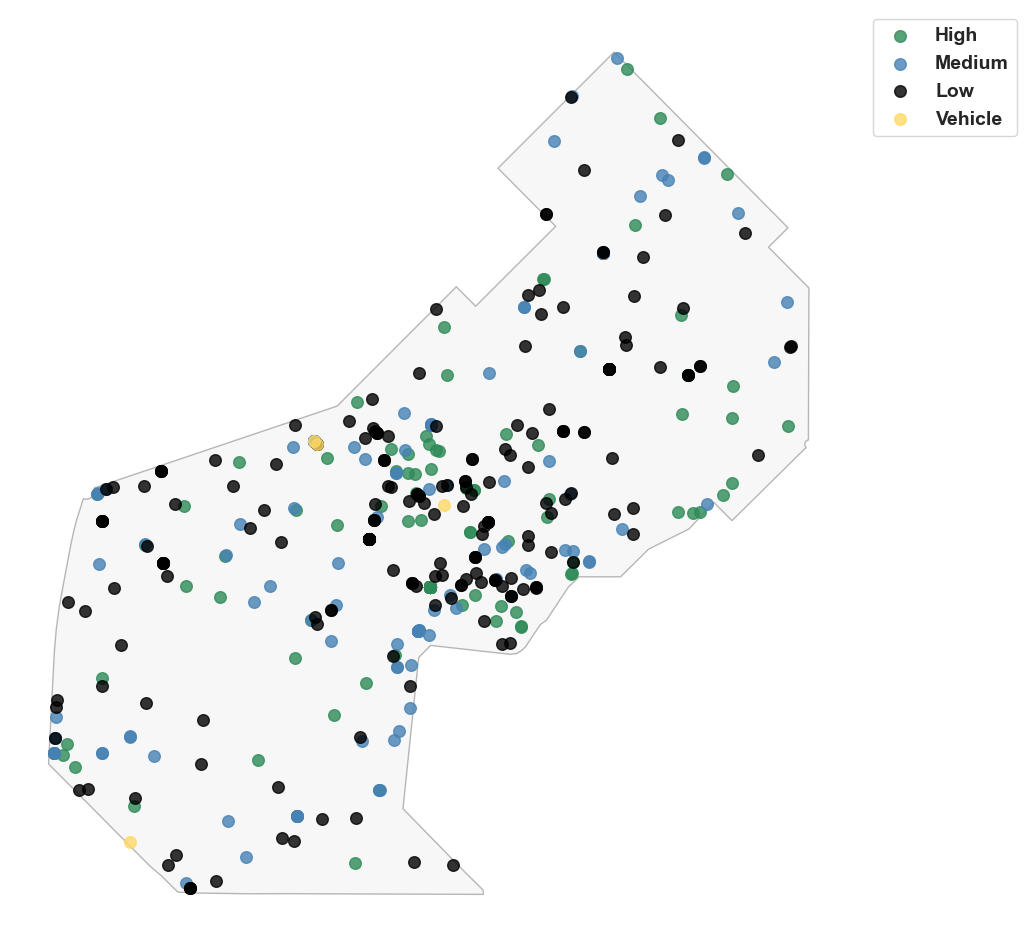

Number of AEDs inside Eixample: 539


In [36]:
# Filtrar Eixample pel codi de districte
eixample_gdf = gdf_districtes[gdf_districtes['DISTRICTE'] == '02']

# Crear un únic poligon de l'Eixample
eixample_polygon = eixample_gdf.unary_union

# AEDs dins l'Eixample
eixample_aeds = gdf_desf_bcn[gdf_desf_bcn.geometry.within(eixample_polygon)].copy()

# Colors per accessibilitat (com abans)
access_colors_cb = {
    "High": "#2E8B57",
    "Medium": "#4682B4",
    "Low": "#000000",
    "Vehicle": "#FFD966"
}

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibuixar Eixample
eixample_gdf.plot(
    ax=ax,
    color="#f5f5f5",
    edgecolor="#999999",
    linewidth=1.0,
    alpha=0.7
)

# Plot AEDs per accessibilitat
for level, color in access_colors_cb.items():
    subset = eixample_aeds[eixample_aeds['accessibilitat'] == level]
    if len(subset) > 0:
        subset.plot(
            ax=ax,
            markersize=70,
            color=color,
            label=level,
            alpha=0.8
        )

# Llegenda i títol
ax.axis('off')
ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/Eixample_AEDs.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Number of AEDs inside Eixample: {len(eixample_aeds)}")


/var/folders/p8/854sw5z13s1_xzp8dpwctx1m0000gn/T/ipykernel_1470/262762779.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(unique_categories))


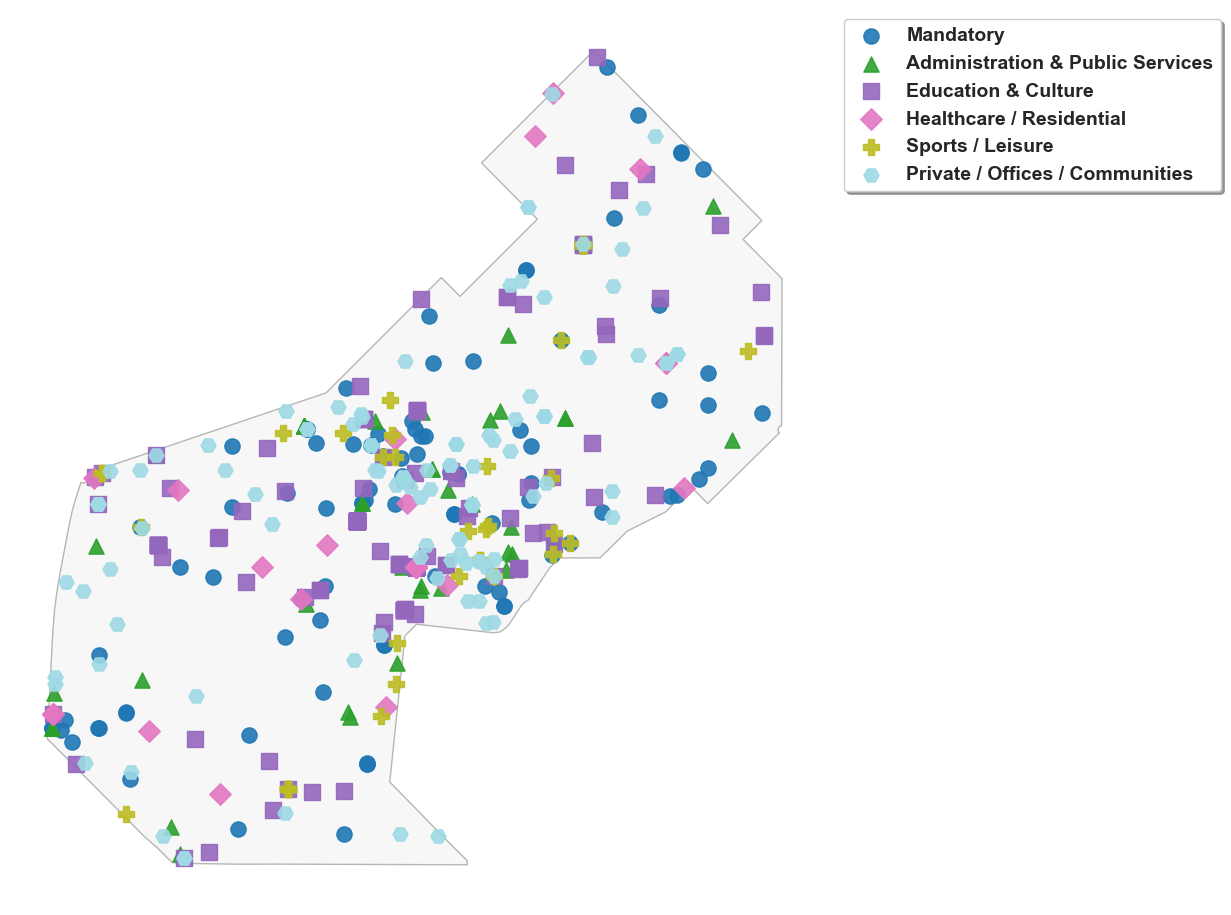

Number of AEDs inside Eixample: 539


In [37]:
unique_categories = eixample_aeds['macro_categories'].unique()

cmap = cm.get_cmap("tab20", len(unique_categories))
categoria_colors = {cat: cmap(i) for i, cat in enumerate(unique_categories)}

shapes = ['o', '^', 's', 'D', 'P', 'H', 'v', '<', '>']
categoria_shapes = {cat: shapes[i % len(shapes)] for i, cat in enumerate(unique_categories)}


fig, ax = plt.subplots(figsize=(12, 12))

# Dibuixar l’Eixample
eixample_gdf.plot(
    ax=ax,
    color="#f5f5f5",
    edgecolor="#999999",
    linewidth=1.0,
    alpha=0.7
)

# Plot AEDs per categoria amb shapes i colors
for cat in unique_categories:
    subset = eixample_aeds[eixample_aeds['macro_categories'] == cat]
    if len(subset) > 0:
        subset.plot(
            ax=ax,
            markersize=120,  # una mica més gran
            color=categoria_colors[cat],
            label=cat,
            alpha=0.9,
            marker=categoria_shapes[cat],
        )

ax.axis('off')
ax.legend(
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=True,
    shadow=True
)

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/Eixample_category.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Number of AEDs inside Eixample: {len(eixample_aeds)}")
